In [16]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from dicom import read_file as read_dicom_file
import os
from skimage.io import imsave
from glob import glob
from itertools import groupby

# Preprocessing
Here we preprocess the TCGA DICOM files for making some simple training data for the exercise

In [9]:
all_dicoms = glob('/Users/mader/Documents/TCGA_DICOMS/DOI/*/*/*/*.dcm')
print('DICOMS found:', len(all_dicoms))

DICOMS found: 82093


In [17]:
fold_list = [(series_id, list(slices)) for series_id,slices in groupby(all_dicoms, lambda x: os.path.dirname(x))]
middle_slice_dicoms = [sorted(slices)[int(len(slices)/2)] for series_id,slices in fold_list if len(slices)>10] # at least 10 slices
print('Number of Middle Slices', len(middle_slice_dicoms))

Number of Middle Slices 589


In [51]:
def parse_dicom(in_file):
    test_dicom = read_dicom_file(in_file)
    return {'Age': test_dicom.get('PatientAge',None), 
            'Modality': test_dicom.Modality,
           'Contrast': test_dicom.get((0x18,0x10),None), 'Image': 
           test_dicom.pixel_array+test_dicom.get('RescaleIntercept',0)}
full_dicom_images = [parse_dicom(c_slice) for c_slice in tqdm(middle_slice_dicoms)]



  0%|          | 0/589 [00:00<?, ?it/s]

  3%|▎         | 19/589 [00:00<00:03, 182.75it/s]

  7%|▋         | 42/589 [00:00<00:02, 194.43it/s]

 11%|█         | 66/589 [00:00<00:02, 205.97it/s]

 15%|█▌        | 91/589 [00:00<00:02, 216.69it/s]

 20%|██        | 119/589 [00:00<00:02, 231.41it/s]

 24%|██▍       | 140/589 [00:00<00:02, 199.96it/s]

 27%|██▋       | 159/589 [00:00<00:02, 187.25it/s]

 30%|███       | 178/589 [00:00<00:02, 175.12it/s]

 33%|███▎      | 196/589 [00:00<00:02, 171.91it/s]

 37%|███▋      | 215/589 [00:01<00:02, 174.16it/s]

 40%|███▉      | 233/589 [00:01<00:02, 148.20it/s]


 42%|████▏     | 249/589 [00:01<00:02, 141.43it/s]

 45%|████▍     | 264/589 [00:01<00:02, 137.54it/s]

 47%|████▋     | 279/589 [00:01<00:02, 134.99it/s]

 50%|████▉     | 293/589 [00:01<00:02, 126.92it/s]

 52%|█████▏    | 306/589 [00:01<00:02, 125.96it/s]

 54%|█████▍    | 319/589 [00:01<00:02, 124.77it/s]

 57%|█████▋    | 337/589 [00:02<00:01, 136.04it/s]

 60%|██████    | 354/589

In [60]:
dicom_df = pd.DataFrame(full_dicom_images)
dicom_df = dicom_df.query('Modality == "CT"').query('Age == Age')
dicom_df['Age'] = dicom_df['Age'].map(lambda x: int(x[:-1]))
dicom_df['Contrast'] = dicom_df['Contrast'].map(lambda x: x is None)
print('Pruned List', dicom_df.shape)
dicom_df.sample(1)

Pruned List (475, 4)


,Age,Contrast,Image,Modality
542,47,False,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,...",CT


Number with and without contrast

In [62]:
dicom_df['Contrast'].value_counts()

True     398
False     77
Name: Contrast, dtype: int64

The age range for the dataset

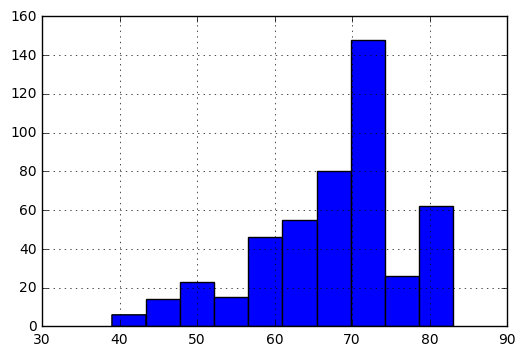

In [64]:
%matplotlib inline
dicom_df['Age'].hist()

In [66]:
out_dir = '../images/'
if not os.path.exists(out_dir): os.mkdir(out_dir)
for idx, cur_row in dicom_df.iterrows():
    age = cur_row['Age']
    contrast = cur_row['Contrast']
    n_img = cur_row['Image']
    imsave(os.path.join(out_dir, 'ID_%04d_AGE_%04d_CONTRAST_%d_CT.tif' % (idx, age, contrast)),
           n_img.astype(np))

In [68]:
dicom_df[['Age', 'Contrast']].to_csv('../data/overview.csv')

In [69]:
np.savez_compressed('../data/full_archive.npz', idx = dicom_df.index, image = dicom_df.Image)